In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sci
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = ''

2025-01-25 00:33:24.000404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 00:33:24.000436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 00:33:24.001516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 00:33:24.008197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 00:33:25.532321: W tensorflow/comp

In [4]:
temperatures = np.array([round(t, 4) for t in np.arange(0.2, 0.701, 0.005)])
temp2theta = {
    t: np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

In [2]:
# load model
reload(gb1)
model = gb1.EnrichmentFeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.load('gb1-h10-5k-030123')

# get predictions for all x in X
predall_n = model.predict(gb1.ALL_NOSTOP_AA_SEQS)

In [5]:
temp2paa_lxa = {}
pareto_tx2 = np.empty([temperatures.size, 2])

# NNK (training) probability for each x in X
logptrain_n = gb1.get_nostop_loglikelihood(gb1.ALL_NOSTOP_AA_OHE, gb1.PAA_NNK_LXA)
ptrain_n = np.exp(logptrain_n)
# mean training label
meantrainy = np.sum([p * gb1.SEQ2YVAR[seq][0] for p, seq in zip(ptrain_n, gb1.ALL_NOSTOP_AA_SEQS)])

for t, (temp, theta_lxa) in enumerate(temp2theta.items()):
    print('Temperature = {:.4f}'.format(temp))
    
    # convert to AA probabilities
    paa_lxa = gb1.get_aa_probs_from_nuc_probs(gb1.normalize_theta(theta_lxa))
    temp2paa_lxa[temp] = paa_lxa
    
    # probability for each x in X
    logpdesign_n = gb1.get_nostop_loglikelihood(gb1.ALL_NOSTOP_AA_OHE, paa_lxa)
    pdesign_n = np.exp(logpdesign_n)
    
    # mean prediction for this design distribution
    meanpred = pdesign_n.dot(predall_n)
    pareto_tx2[t, 0] = meanpred
    
    # KL from NNK
    kl = ptrain_n.dot(logptrain_n - logpdesign_n)
    pareto_tx2[t, 1] = kl
    
    print('Mean prediction, KL: {:.2f}, {:.2f}'.format(meanpred, kl))
    print()

Temperature = 0.2000
Mean prediction, KL: 1.66, 21.40

Temperature = 0.2050
Mean prediction, KL: 1.61, 20.32

Temperature = 0.2100
Mean prediction, KL: 1.03, 17.37

Temperature = 0.2150
Mean prediction, KL: 1.26, 16.88

Temperature = 0.2200
Mean prediction, KL: 1.59, 19.78

Temperature = 0.2250
Mean prediction, KL: 1.59, 20.00

Temperature = 0.2300
Mean prediction, KL: 1.21, 16.28

Temperature = 0.2350
Mean prediction, KL: 1.58, 19.42

Temperature = 0.2400
Mean prediction, KL: 1.55, 20.47

Temperature = 0.2450
Mean prediction, KL: 1.18, 15.91

Temperature = 0.2500
Mean prediction, KL: 1.16, 15.34

Temperature = 0.2550
Mean prediction, KL: 1.52, 19.22

Temperature = 0.2600
Mean prediction, KL: 1.10, 14.50

Temperature = 0.2650
Mean prediction, KL: 1.10, 14.66

Temperature = 0.2700
Mean prediction, KL: 1.39, 17.55

Temperature = 0.2750
Mean prediction, KL: 1.47, 19.13

Temperature = 0.2800
Mean prediction, KL: 0.93, 13.17

Temperature = 0.2850
Mean prediction, KL: 1.44, 18.63

Temperatur

In [6]:
# for resis 12.13.24
row_labels = np.array([round(temp, 4) for temp, _ in temp2theta.items()])
df = pd.DataFrame(pareto_tx2, columns=["mean prediction", "KL divergence"], index=row_labels)
df.to_csv('../data-for-resis-121324/fig2.csv')

In [6]:
def remove_stop_codon(paa_lxa):
    idx = gb1.AA.index('*')
    newpaa_lxa = np.hstack([paa_lxa[:, : idx], paa_lxa[:, idx + 1:]])
    newpaa_lxa = newpaa_lxa / np.sum(newpaa_lxa, axis=1, keepdims=True)
    return newpaa_lxa

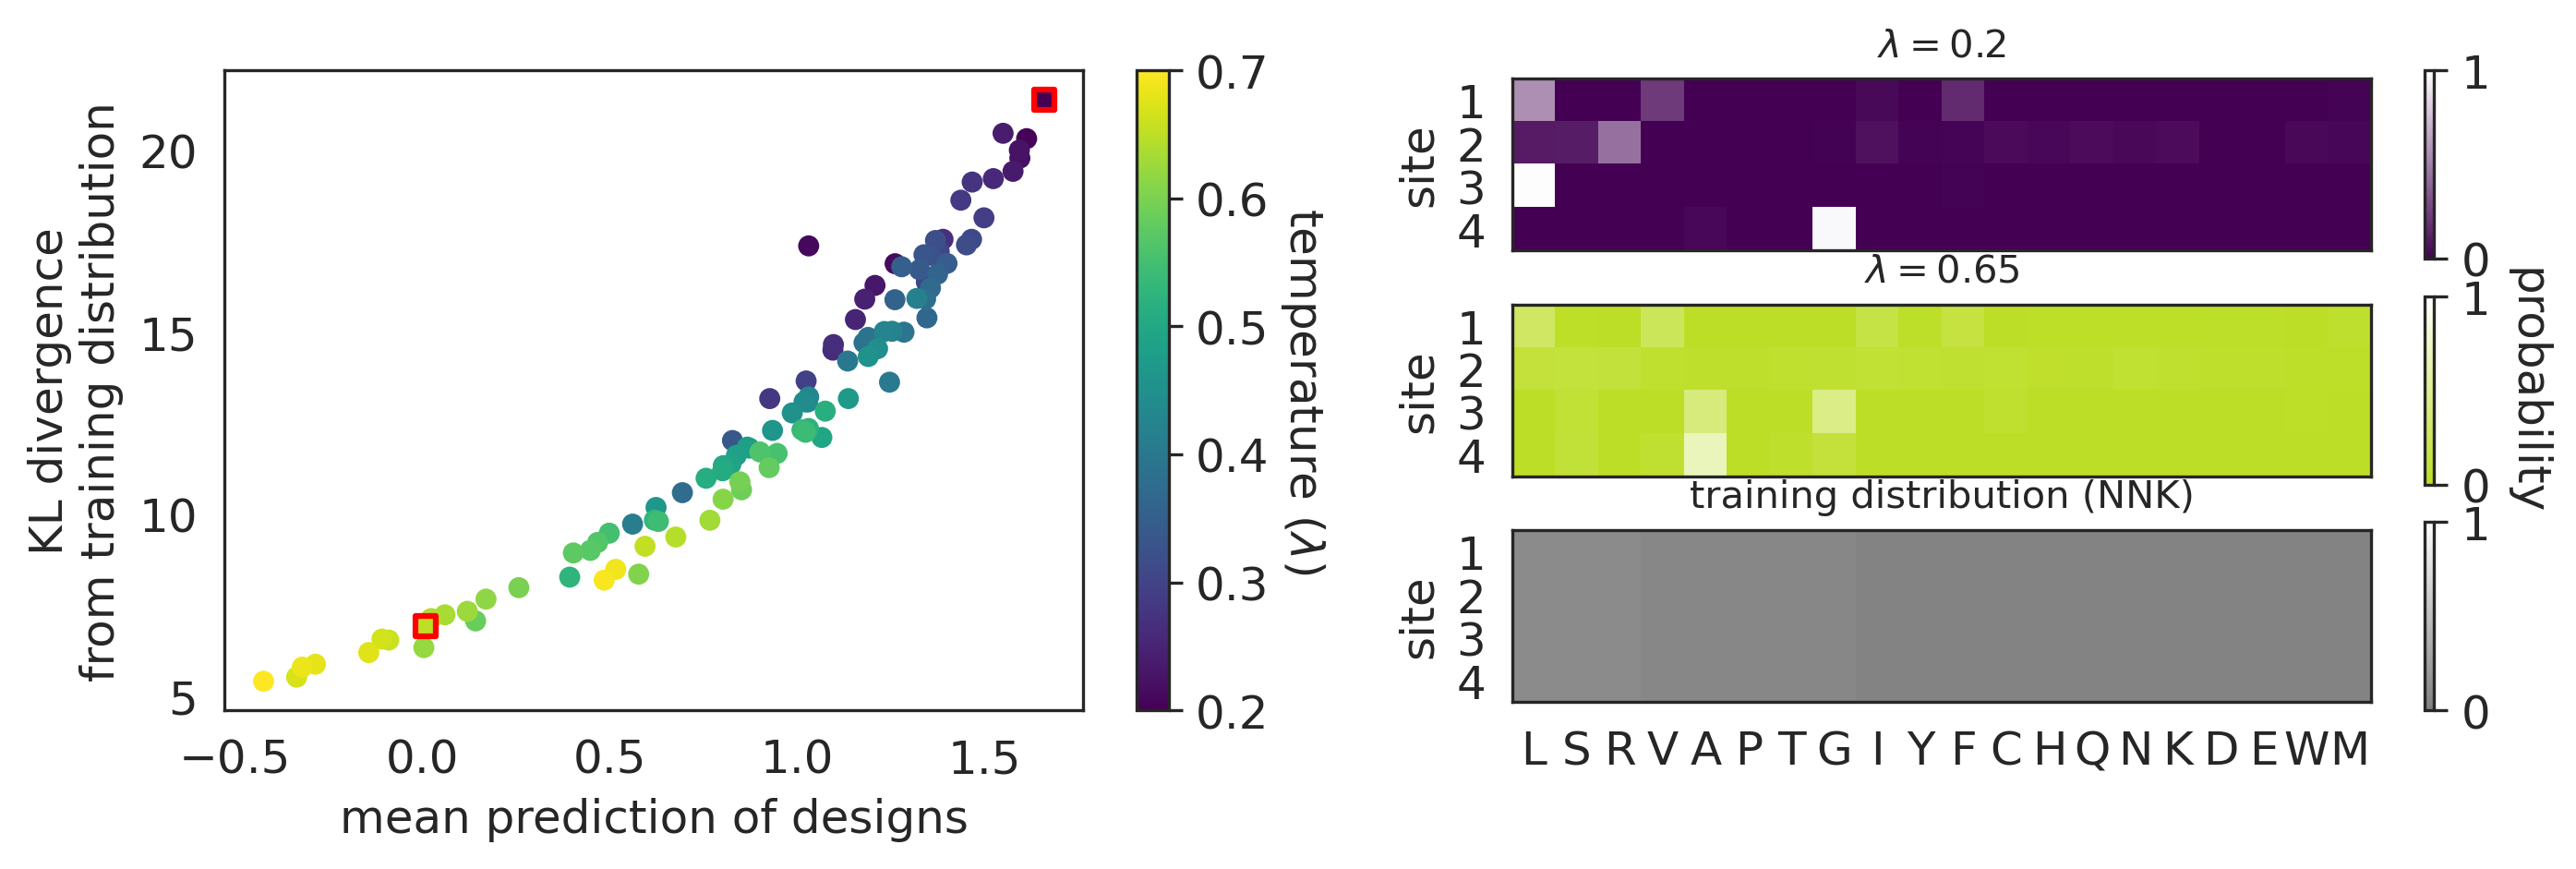

In [7]:
# explanatory figure
sns.set_style('white')
temps = [0.2, 0.65]

fig = plt.figure(figsize=(11, 3), dpi=300)
gs0 = GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs0[:, 0])
axs = [fig.add_subplot(gs0[i, 1]) for i in range(3)]

# trade-off
sc = ax0.scatter(pareto_tx2[:, 0], pareto_tx2[:, 1], cmap='viridis', c=temperatures, alpha=1, s=20)
cbar = fig.colorbar(sc, ax=ax0)
cbar.set_label(r'temperature ($\lambda$)', rotation=270, labelpad=15)
ax0.set_xlabel('mean prediction of designs')
ax0.set_ylabel('KL divergence\nfrom training distribution')
# ax0.scatter(meantrainy, 0, marker='^', c='white', edgecolors='k', s=40, label='training distribution')
# ax0.legend();

for t, temp in enumerate(temps):
    paa_lxa = remove_stop_codon(temp2paa_lxa[temp])
    cmap = LinearSegmentedColormap.from_list(None, [sc.to_rgba(temp), 'white'], N=256, gamma=1.0)    
    im = axs[t].imshow(paa_lxa, cmap=cmap, vmin=0, vmax=1)
    if t == 1:
        cbar = plt.colorbar(im, ax=axs[t], ticks=[0, 1])
        cbar.set_label('probability', labelpad=15, rotation=270)
    else:
        plt.colorbar(im, ax=axs[t], ticks=[0, 1])
    axs[t].grid(False)
    axs[t].set_title(r'$\lambda = ${}'.format(temp), fontsize=10)
        
    axs[t].set_yticks(range(4), range(1, 5))
    axs[t].set_ylabel('site')
    axs[t].set_xticks(range(len(gb1.AA) - 1))
    axs[t].set_xticklabels([])
    
    idx = np.where(temperatures == temp)[0]
    ax0.scatter(pareto_tx2[idx, 0], pareto_tx2[idx, 1], marker='s', color=sc.to_rgba(temp), s=30,
                linewidth=1.5, edgecolor='red')
        
cmap = LinearSegmentedColormap.from_list(None, ['grey', 'white'], N=256, gamma=1.0)
im = axs[2].imshow(remove_stop_codon(gb1.PAA_NNK_LXA), cmap=cmap, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[2], ticks=[0, 1]);
axs[2].set_title('training distribution (NNK)', fontsize=10)
axs[2].set_yticks(range(4), range(1, 5))
axs[2].set_ylabel('site')
axs[2].set_xticks(range(len(gb1.AA) - 1))
idx = gb1.AA.index('*')
axs[2].set_xticklabels(gb1.AA.upper()[: idx] + gb1.AA.upper()[idx + 1 :]);

1.0171511098621726 0.7944508082924071 0.6780329592981091


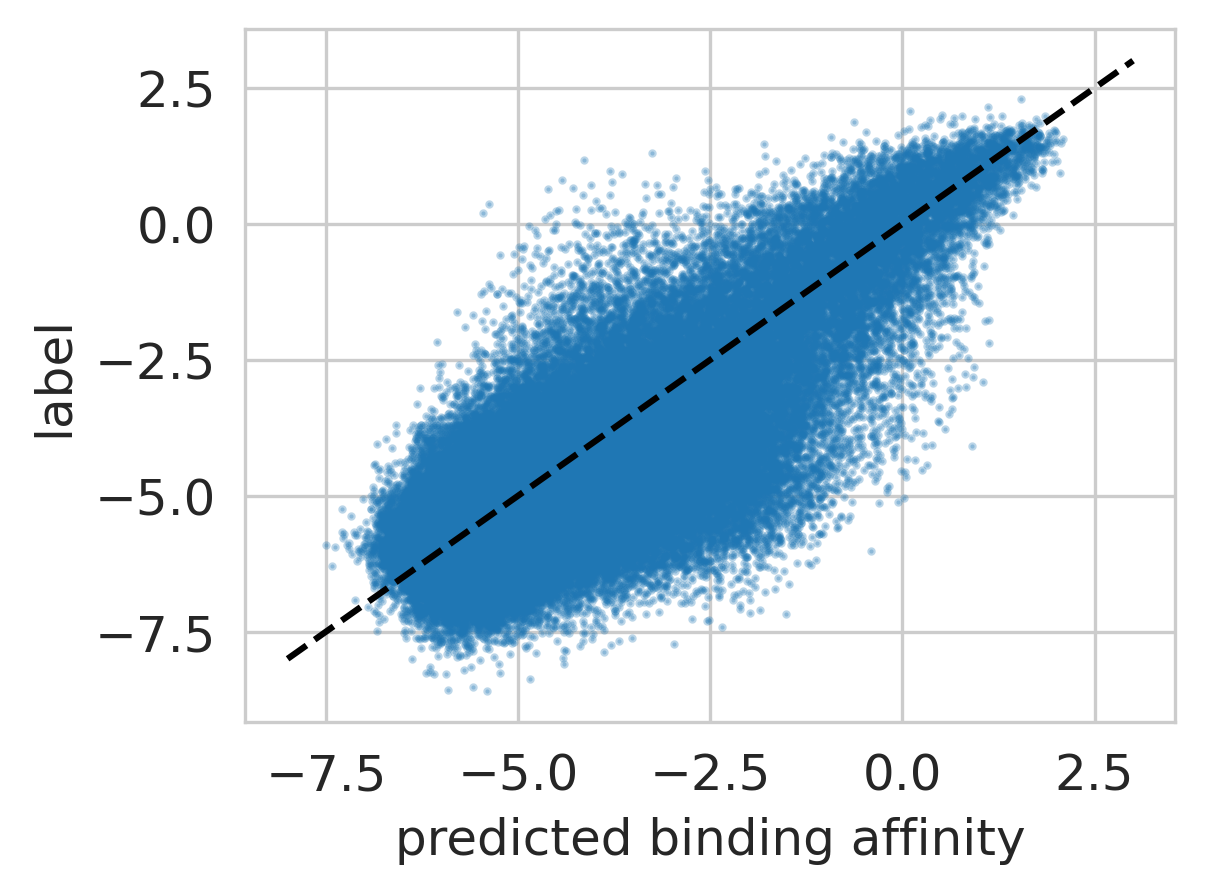

In [7]:
plt.figure(figsize=(4, 3), dpi=300)
yall_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in  gb1.ALL_NOSTOP_AA_SEQS])
plt.scatter(predall_n, yall_n, alpha=0.3, s=1);
plt.plot([-8, 3], [-8, 3], '--k')
plt.xlabel('predicted binding affinity');
plt.ylabel('label');

rmse = np.sqrt(np.mean(np.square(yall_n - predall_n)))
r, _ = sci.stats.pearsonr(yall_n, predall_n)
rho, _ = sci.stats.spearmanr(yall_n, predall_n)

print(rmse, r, rho)

In [9]:
# for resis 12.13.24
data_tx2 = np.hstack([predall_n[:, None], yall_n[:, None]])
df = pd.DataFrame(data_tx2, columns=["prediction", "label"])
df.to_csv('../data-for-resis-121324/fig5.csv')